# Understanding Instacart's Customers

### Code may take a long time (maybe more than 1 hour, because of very large dataset) to run in one single file. We have divided the same code in three parts in three different jupyter notebooks to look into different analysis separately. 

## Introduction

Instacart is an online retail company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers, which gets delivered by a personal shopper. 

**The Data**: Instacart recently released the dataset, which contains a sample of over 3 million grocery orders from more than 200,000 Instacart app users. For each user, the dataset provides between 4 and 100 of their orders, with the sequence of products purchased in each order. It also provides the week and hour of day the order was placed, and a relative measure of time between orders.

**Objective**: The aim of this project work is to analyze the data, understand customer behaviour and recommend strategies to Instacart in order to maximize their revenues and also enhance their customers’ experience. It is interesting because we can realize many different ways in which retailers can leverage customer buying patterns to make them spend more.

#### Summary of findings:
We looked at the data from many different point of views and the interesting insights we found are as follows:

- **Analysis**: Finding relations between products to see what groups of products do most customers buy together

    - **Insight**: 
        - Purchasing patterns of customers revealed affinity of one product to other. For example, a person who buys household products would also buy personal care items.
        - Using the knowledge of product associations we can build a product recommender system to proactively suggest products to customers as they build thier orders. Such a sysytem could lead to $25 million increase in revenue
    
    
- **Analysis**: Finding the hour of day during which most customers order

    - **Insight**: Frequency of orders by hour of the day. This gives us the idea about the peak hours for online grocery shopping and insights to increase sales during lean hours. We found one of the possible reasons for the dip in orders after 5 pm, which could potentially be the most productive hours.


- **Analysis**: Finding how many of our customers tend to keep ordering the same items

    - **Insight**: Re-order pattern of users provides an insight into what percentage of total items bought in an order were also in the previous order of the user. This is important to suggest introducing a re-order tab/button on the app to enhance user experience


- **Analysis**: Analysis of most frequently bought items or most visited grocery department.

    - **Insight**: Information of the most visited grocery department tells Instacart that they should focus on specific customers who are using specific departments frequently. Since most of those departments include price sensitive products, it is important to suggest incentives to specific customers to maximize revenue stream.
  


## Loading required data and libraries

In [1]:
#Importing all Libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import random

C:\Users\ktaey\Anaconda3\envs\py27\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Link to download the required data provided by Instacart

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on July 18, 2017.

### Note

- The data at the link keeps changing therefore we have uploaded the first dataset we used, to a dropbox **link:
https://www.dropbox.com/sh/jt2l9k6sd6qlebu/AACx8UgigXpfM87_Nsl7mh34a?dl=0**

- We have also included the extra data files in which we have added assumed prices for each products. Part of additional analysis that can be done if we have actual data.

- Please have all the files in the above dropbox in your current working directory for the code to work as intended

In [2]:
#Importing All Raw Data Files
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
#order_products_prior = pd.read_csv("instacart_2017_05_01/order_products__prior.csv")
#order_products_train = pd.read_csv("instacart_2017_05_01/order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

File containing prices for products is provided separately in a csv file named - 'master_products.csv'. Please be sure to place this file in your working directory.

As part of understanding customer behaviour we start by looking at what products do customers prefer to buy together in one order. This is generally called the affinity analysis.

# Affinity Analysis

## Department affinity

In the context of retail analytics, especially market basket analysis, affinity index between two items is a measure of how strongly the presence of one particular item in an order indicates the presence of the second item. This gives us an idea of what are the products which customers prefer to buy together generally.

Affinity can be calculated at any level of the product hierarchy.

For initial understanding of the product relations that exist among instacart orders, we perform the affinity analysis at a department level.

As we are evaluating the relation between two departments, we see how strongly the presence of **Driver Department** *drives* the presence of **Driven Department**.

#### Steps to calculate affinity

- From the table which has order and product level information, calculate the number of orders for each department

- Cross join the table which has order and department level information on itself to get all the pairs of departments which are bought in each order
    - Remove the combinations of the same department as driver and driven

- Count the number of distinct orders in which each department pair is present

- Once the above quantities are calculated, we calculate the **confidence** metric which is the proportion of the driven department orders in which both the departments are present.

- Then we calculate **support** which is the proportion of all orders in which driver department is present

- Finally, affinity is calculated as **Affinity = Confidence / Support**

- For the department combinations where the support is extremely low the affinity value will be very high. This means when the driver department is a rarely bought department the affinity value is very high but its based on very few data points. Therefore, we remove the combinations with the bottom 5% confidence value to make sure that the affinity values are reliable

#### Computational complexities encountered

-  As a cross join on order-department level data is involved, the raw data to be processed turns out to be n(n-1) time the number of order-department combinations

- In the given data the total number of orders is 3.4 million, which means the order-department combinations are nearly 30 million. Therefore, analyzing all the data at a time would mean processing nearly 900 million rows of data at one point of time

**Resolution**

In order, to avoid this problem we analyzed 100 random samples of size 50,000 orders and thus calculated 100 estimates of the affinity indices between every pair of departments. We have reported the mean and standard deviation of the affinity index for each department pair.

It can be seen that the standard deviation is low compared to the mean in all the cases and thus we can say that the affinity indices calculated are reliable

In [6]:
############################################################################################################################
################# Code to calculate the affinity between departments from 50000 random orders (100 iterations)##############
############################################################################################################################


dept_affinity_list = [] ## Creating a list to hold department affinities for each iteration
for i in range(100):
    # Select a set of 50000 random orders
    total_orders = 50000
    order_list = pd.DataFrame(random.sample(orders.order_id[orders.eval_set == 'prior'],total_orders))
    order_list.rename(columns={0:'order_id'},inplace=True)

    ## Read the order products data in chunks for only selected orders
    outResult=[]
    chunksize = 10 ** 6
    for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                             dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
        chunk1 = pd.merge(left = chunk, right = order_list,on = 'order_id', how = 'inner')
        outResult.append(chunk1)

    order_prod_rand = pd.DataFrame(pd.concat(outResult))

    ## Merging product hierarchy to order product
    order_prod_dept_rand = pd.merge(left = order_prod_rand, right = products, on = 'product_id',how='inner')

    ## Order department level data
    order_dept_rand = order_prod_dept_rand.groupby(['order_id','department_id'])['product_id'].count().reset_index()

    order_dept_rand = order_dept_rand.loc[:,['order_id','department_id']]

    ## Calculating orders for each department
    dept_ord_count = order_dept_rand.groupby(['department_id']).count().reset_index()

    dept_ord_count.rename(columns={'order_id':'count_orders'},inplace=True)

    ## Cross joining to get pairs of products in each order
    order_dept_rand_cross = pd.merge(left = order_dept_rand, right = order_dept_rand, on = 'order_id', how= 'inner')

    order_dept_rand_cross = order_dept_rand_cross[order_dept_rand_cross['department_id_x']!=order_dept_rand_cross['department_id_y']]

    order_dept_rand_cross.rename(columns= {'department_id_x':"driver_dept","department_id_y":"driven_dept"},inplace=True)

    dept_common_orders = order_dept_rand_cross.groupby(['driver_dept','driven_dept']).count().reset_index()

    dept_common_orders.rename(columns={'order_id':'count_common_orders'},inplace=True)

    ## join the above table to aisle order count to get number of driver and driven orders
    dept_aff = dept_common_orders.merge(dept_ord_count,left_on = 'driver_dept',right_on = 'department_id',how = 'inner')

    dept_aff.rename(columns={'count_orders':'driver_orders'},inplace=True)

    dept_aff = dept_aff.drop('department_id',axis = 1)

    dept_aff = dept_aff.merge(dept_ord_count,left_on = 'driven_dept',right_on = 'department_id',how = 'inner')

    dept_aff.rename(columns={'count_orders':'driven_orders'},inplace=True)
    dept_aff = dept_aff.drop('department_id',axis = 1)
    
    dept_aff.sort_values(['driver_dept','driven_dept'],ascending=[1,1], inplace=True)
    
    ## Add total orders as 50000
    dept_aff['Total_orders'] = total_orders
    
    ## Calculate affinity
    dept_aff['Confidence'] = dept_aff['count_common_orders'] / dept_aff['driven_orders']
    dept_aff['Support'] = dept_aff['driver_orders'] / dept_aff['Total_orders']
    dept_aff['Affinity'] = dept_aff['Confidence'] / dept_aff['Support']
    dept_aff['iteration'] = i
    dept_affinity_list.append(dept_aff)

## Remove the combinations with bottom 5% support value in each iteration    
for i in range(100):
    dept_affinity_list[i] = dept_affinity_list[i][dept_affinity_list[i]["Support"] >= \
                                                dept_affinity_list[i]['Support'].quantile(0.05)]

#### Combine the affinity results from all iterations

In [7]:
dept_affinity = pd.DataFrame(pd.concat(dept_affinity_list))

## Calculate the mean and standard deviation of affinities calculated from 100 iterations
dept_affinity_final = dept_affinity.groupby(['driver_dept','driven_dept']).agg({'Affinity':[np.mean,np.median, np.std]}).reset_index()

dept_affinity_final.columns = [' '.join(col).strip() for col in dept_affinity_final.columns.values]

dept_affinity_final = dept_affinity_final.merge(departments,left_on= 'driver_dept',right_on='department_id',how = 'inner')
dept_affinity_final.rename(columns={'department':'driver_name'},inplace=True)
dept_affinity_final.drop('department_id',axis=1,inplace=True)


dept_affinity_final = dept_affinity_final.merge(departments,left_on= 'driven_dept',right_on='department_id',how = 'inner')
dept_affinity_final.rename(columns={'department':'driven_name'},inplace=True)
dept_affinity_final.drop('department_id',axis=1,inplace=True)


dept_affinity_final.sort_values(['Affinity mean'],ascending=0,inplace=True)

dept_affinity_table = pd.pivot_table(dept_affinity_final, values='Affinity mean', index=['driver_name'],
                    columns=['driven_name'], aggfunc=np.sum)

#### Top affined departments

In [8]:
dept_affinity_final.head(20)

,driver_dept,driven_dept,Affinity mean,Affinity median,Affinity std,driver_name,driven_name
3,5,2,3.079484,3.047970,0.397480,alcohol,other
61,2,5,3.047853,2.993146,0.358530,other,alcohol
66,8,5,2.519023,2.505533,0.285768,pets,alcohol
124,5,8,2.519023,2.505533,0.285768,alcohol,pets
307,8,17,2.503908,2.503970,0.111374,pets,household
135,17,8,2.503908,2.503970,0.111374,household,pets
195,17,11,2.268993,2.267120,0.043583,household,personal care
310,11,17,2.268993,2.267120,0.043583,personal care,household
129,11,8,2.242202,2.241363,0.136180,personal care,pets
187,8,11,2.242202,2.241363,0.136180,pets,personal care


#### Plotting department level affinities

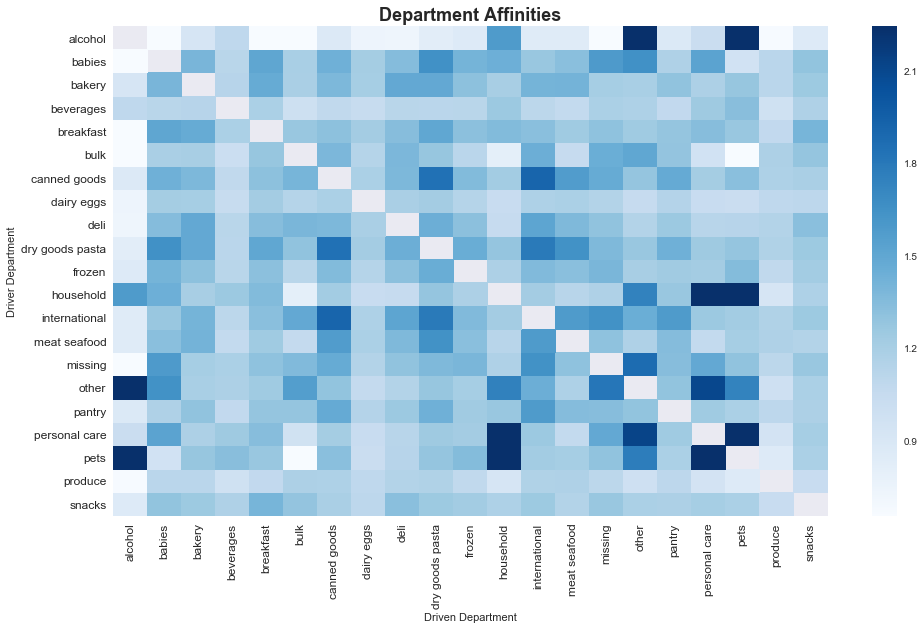

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.heatmap(dept_affinity_table, robust = True,cmap = 'Blues')

ax.set_title(label='Department Affinities', fontweight='bold', fontsize=18)
ax.set(xlabel='Driven Department' , ylabel='Driver Department')
ax.tick_params(labelsize=12)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('seabornPandas.png', dpi=326)
plt.show()

#### Results
- It can be seen clearly that there are very strong relations between few product types like household and personal care
- This information can be used to build a recommendation system that would suggest products to customers as they build their products

#### Note
- In order to actually build a product recommendation we need the affinities at a more granular level
- Therefore, we also calculated the aisle level affinities and presented it in the appendix of the report

## Calculating the expected revenue upon using the product recommender system

As we do not have any price data from Instacart, we need to make some assumptions to calculate the expected revenue. 

#### Assumptions:
- The prices of the products are predicted based on a heuristic range of prices taken for each department
    - File containing this prices for products is provided separately in a csv file named - 'master_products.csv'. Please be sure to place this file in your working directory.
- If an order contains a driver department product and does not contain any product from a highly affined driven department, we expect that our recommender system would add a product of the driven department with average price of that department
- Affinity value above 2 is considered high

#### Steps for calculating expected revenue:
- We calculate the number of orders containing both the driver and driven departments for highly affined department pairs
- We join a table containing the number of driver department orders
- The difference between the driver department orders and the common orders is the number of orders in which the driver department was bought but not the driven
- We assume that 20% of such orders will have 1 item from driven department if we had a product suggestion
- So we use the average price of the driven department to calculate the expected additional revenue generated by adding a driven department product

In [10]:
#################   Calculating the department level orders from all orders  ####################

order_dept_all=[]
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = products, on = 'product_id', how = 'inner')
    chunk2 = chunk1.groupby(['order_id','department_id'])['product_id'].count().reset_index()
    chunk3 = chunk2.groupby(['department_id'])['order_id'].count().reset_index()
    order_dept_all.append(chunk3)

order_dept_all_1 = pd.DataFrame(pd.concat(order_dept_all))

order_dept_all_1 = order_dept_all_1.groupby(['department_id'])['order_id'].sum().reset_index()

order_dept_all_1.rename(columns={'order_id':'no_of_orders'}, inplace= True)

order_dept_all_1 = order_dept_all_1.merge(departments,on='department_id',how = 'inner')

order_dept_all_1['dept_penetration'] = order_dept_all_1['no_of_orders'] / (len(orders.order_id[orders.eval_set == 
                                                                                                 'prior'].unique()))

order_dept_all_1.sort_values(['dept_penetration'],ascending=0,inplace=True)

In [11]:
#################   Loading the product level price data, which was assumed   ###########################
product_price = pd.read_csv("master_products.csv")
order_prior = orders[orders.eval_set == 'prior']
order_chunks = [order_prior[x:x+50000] for x in xrange(0, len(order_prior), 50000)]


#################   Calculating the number of orders for each department pair ##########################

order_dept2_all=[]
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = products, on = 'product_id', how = 'inner')
    chunk2 = chunk1.groupby(['order_id','department_id'])['product_id'].count().reset_index()
    chunk3 = chunk2.merge(chunk2,on = 'order_id',how = 'inner')
    chunk3 = chunk3[chunk3['department_id_x']!=chunk3['department_id_y']]
    chunk4 = chunk3.groupby(['department_id_x','department_id_y'])['order_id'].count().reset_index()
    order_dept2_all.append(chunk4)

order_dept2_all_1 = pd.DataFrame(pd.concat(order_dept2_all))
order_dept2_all_1 = order_dept2_all_1.groupby(['department_id_x','department_id_y'])['order_id'].sum().reset_index()
order_dept2_all_1.rename(columns = {'department_id_x':'driver_dept','department_id_y':'driven_dept','order_id':'common_orders'},inplace = True)

################### Join the driver department orders #############################
order_dept2_all_2 = order_dept2_all_1.merge(order_dept_all_1,left_on = 'driver_dept',right_on = 'department_id',how='inner')
order_dept2_all_2.drop(['department_id','dept_penetration'],axis =1,inplace=True)
order_dept2_all_2.rename(columns = {"department":"driver_name",'no_of_orders':'driver_orders'},inplace=True)

################### Calculate the number of orders to which a driven product may be added#########################

expected_dept = order_dept2_all_2.merge(dept_affinity_final.drop(['Affinity median','Affinity std','driver_name'],axis =1), on=['driver_dept','driven_dept'],)
expected_dept = expected_dept[expected_dept['Affinity mean']>=2]
expected_dept['expected_inc_orders'] = (expected_dept['driver_orders'] - expected_dept['common_orders']) / 5

## Calculate the department mean prices to use as driven department mean prices
departmen_mean_price = product_price.groupby(['department_id'])['Price'].mean().reset_index()

############### Calculating the expected increase in revenue#############################
expected_dept = expected_dept.merge(departmen_mean_price,left_on= 'driven_dept',right_on = 'department_id',how='inner')
expected_dept['Expected_revenue_Inc'] = expected_dept['expected_inc_orders']*expected_dept['Price']
expected_revenue_increase = expected_dept.Expected_revenue_Inc.sum()

### Calculating current total revenue

In [12]:
current_revenue = 0
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = product_price, on = 'product_id', how = 'inner')
    current_revenue += chunk1.Price.sum()

### Calculating expected % increse in revenue due to product recommendations

In [13]:
percent_inc = expected_revenue_increase/current_revenue

In [14]:
expected_revenue_increase

24882662.74365098

In [15]:
current_revenue

1949510196L

In [16]:
percent_inc

0.01276354583561818

### Result
By conseravtive estimates we can expect aprrox. $25 million USD increase in revenue if we implement a product reccommandation sysytem.

## Customer Profiling 

For Profiling cutsomers, we are focussing on specific customers:

1) Frequency Analysis: Analysing the average time elapsed between two orders for each customer. This is done for customers having 5-100 orders. This helps us with sending out customised reorder emails timed diffferently for each customer

2) Spend Pattern: Calculating the average spend of each customer

3) Spend vs Frequency- Quadrant Analysis: Identiftying customer behavior, and improving the same to maximixe profits

4) Frequency- By Hour of the Day: Identifying Lean Hours and matching Demand with Supply by incentivising Insta-partners and providing lean Hour offers to boost sales

In [17]:
import os
import pandas as pd
import numpy as np
# Please specify your directory path below and keep all relevent files within the folder
# order_products_prior is a large file- takes time (approx 30 sec) to import
os.chdir("C:\Users\User\Desktop\Project-Computation and Communication")
# below dataset contains info of products brought in each order. This is the most granular dataset
order_products_prior = pd.read_csv("order_products__prior.csv")
aisles = pd.read_csv("aisles.csv")
# Orders dataset is contains information on the orders of regular customers who have placed between 4-100 orders
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [18]:
orders1=orders.drop(['eval_set', 'order_number','order_dow','order_hour_of_day','days_since_prior_order'],axis=1)
orders_grouped=orders1.groupby('user_id').count()
orders_grouped=orders_grouped.reset_index()
orders_grouped1=orders_grouped.rename(index=str, columns={"order_id": "order_count"})
# this is the final orders grouped dataset
orders_grouped2=orders_grouped1.sort_values(['order_count','user_id'], ascending=[True,True])

freq_dist=orders_grouped2.groupby('order_count').count()
freq_dist=freq_dist.reset_index()
freq_dist1=freq_dist.sort_values(['order_count'], ascending=[True])
freq_dist2=freq_dist1.rename(index=str,columns={'user_id':'customer_count'})
# this is the final frequency distribution table- keep it aside

In [19]:
orders2=orders.drop(['eval_set', 'order_number','order_dow','order_hour_of_day'],axis=1)
orderswithcount=pd.merge(orders_grouped2, orders2, how='inner', on='user_id', sort=True)
# removing nulls
orderswithcount=orderswithcount.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [20]:
orderswithcount1=orderswithcount.groupby('user_id').mean()
orderswithcount1=orderswithcount1.reset_index()
orderswithcount2=orderswithcount1.drop('order_id',axis=1)
orderswithcount3=orderswithcount2.rename(index=str,columns={'days_since_prior_order':'avg_order_gap'})

### 1. Frequency Analysis

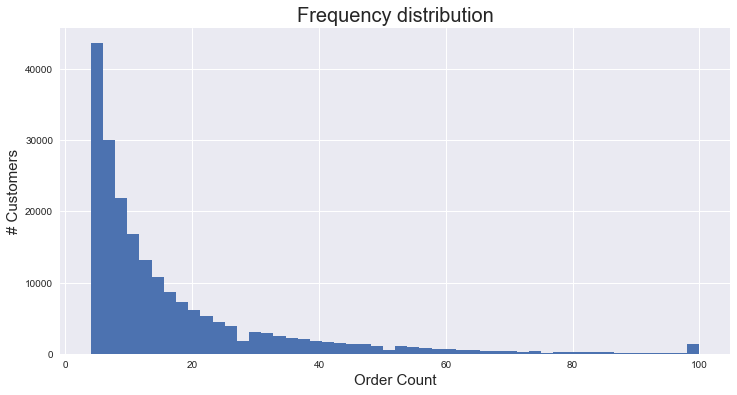

In [21]:
# Visualization 1
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax=plt.subplots(figsize=(12,6))
ax.hist('order_count',data=orderswithcount3,bins=50)
ax.set_title("Frequency distribution",fontsize = 20)
ax.set_ylabel("# Customers",fontsize = 15)
ax.set_xlabel("Order Count",fontsize = 15)
plt.show()

### Results
- This prelim result confirms the hypothesis that there are lesser people as the order count increases

#### 1.1 How Frequently do customers reorder?
Analysing the average time elapsed between two orders for each customer. This is done for customers having 5-100 orders. This helps us with sending out customised reorder emails timed diffferently for each customer

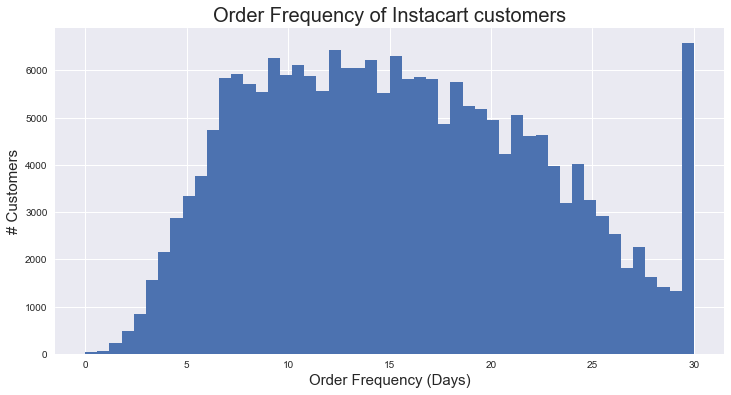

In [22]:
# Visualization 2
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax=plt.subplots(figsize=(12,6))
ax.hist('avg_order_gap',data=orderswithcount3,bins=50)
ax.set_title("Order Frequency of Instacart customers",fontsize = 20)
ax.set_xlabel("Order Frequency (Days)",fontsize = 15)
ax.set_ylabel("# Customers",fontsize = 15)
plt.show()

### Results
- Order frequency shows that even regular customers have a large variation. 25% of the people are above the 20 day mark. We would like to drill down and analyse their spends 

### 2. Spend Pattern
Calculating the average spend of each customer

In [23]:
## departments = pd.read_csv("departments1.csv")# creating a master dataset
# master_products=pd.merge(products, departments, how='inner', on='department_id', sort=True)
# master_products=pd.merge(master_products, aisles, how='inner', on='aisle_id', sort=True)
master_products = pd.read_csv("master_products.csv")# creating a master dataset

In [24]:
# import random
# def randomnum(row):
#     a = np.random.choice(range(row["min"],row["max"]))
#     return a
# master_products["Price"] = master_products.apply(randomnum, axis = 1)

In [25]:
order_products_prior1=order_products_prior.drop(['reordered','add_to_cart_order'],axis=1)
order_products_merged=pd.merge(order_products_prior1,master_products,on='product_id')

In [26]:
order_products_merged_sorted=order_products_merged.sort_values(['order_id'], ascending=[True])

In [27]:
order_products_user=pd.merge(order_products_merged,orders1,how='left',on='order_id')

In [28]:
order_products_user1=order_products_user.groupby('user_id').mean().reset_index()

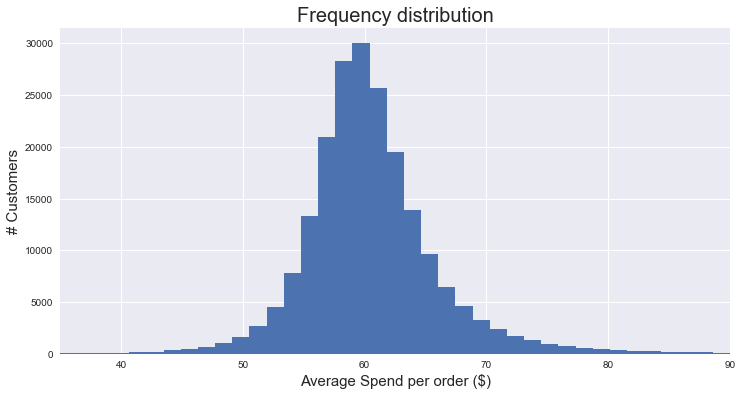

In [29]:
# This is the final file which has average user spend
user_spend=order_products_user1.drop(['order_id', 'product_id','aisle_id','department_id','min', 'max'],axis=1)

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax=plt.subplots(figsize=(12,6))
ax.hist('Price',data=user_spend,bins=100)
ax.set_title("Frequency distribution",fontsize = 20)
ax.set_xlabel("Average Spend per order ($)",fontsize = 15)
ax.set_xlim([35, 90])
ax.set_ylabel("# Customers",fontsize = 15)

### Results
- As expected, the average of Customer spend comes out to be normal distribution. This is because the price information was randomly generated. 
- For drilling down, we should look at a combination of Frequency Analysis and the Spend Analysis

### 3. Spend vs Frequency- Quadrant Analysis
Identiftying customer behavior, and improving the same to maximixe profits

In [30]:
spend_usercount=user_spend.groupby('Price').count().reset_index()
spend_usercount=user_spend.groupby('Price' , as_index = False).count()
spend_freq=pd.merge(user_spend,orderswithcount3,on='user_id')

In [31]:
spend_freq.head()

,user_id,Price,order_count,avg_order_gap
0,1,61.288136,11.0,19.000000
1,2,57.420513,15.0,16.285714
2,3,59.886364,13.0,12.000000
3,4,69.833333,6.0,17.000000
4,5,59.648649,5.0,11.500000


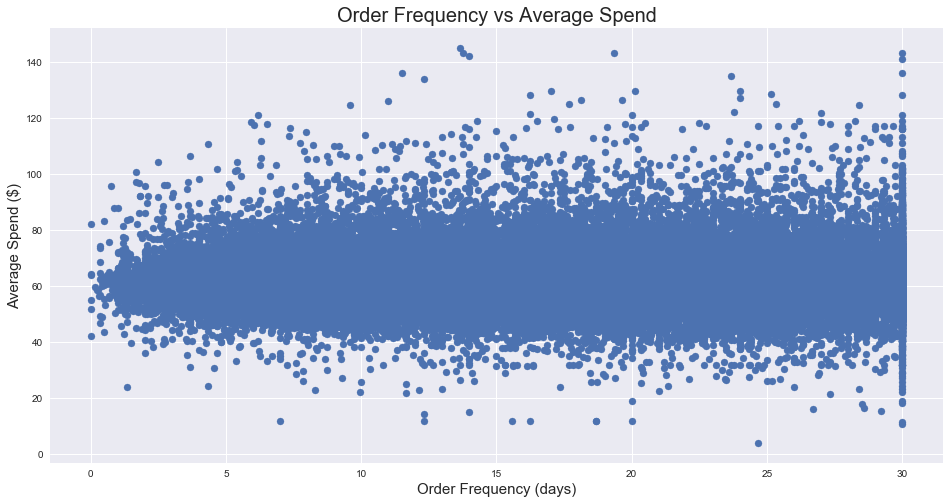

In [32]:
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(16,8))
plt.scatter('avg_order_gap','Price',data=spend_freq)
plt.title('Order Frequency vs Average Spend',fontsize=20)
plt.ylabel('Average Spend ($)',fontsize=15)
plt.xlabel('Order Frequency (days)',fontsize=15)
plt.show()

### Results
- Spend vs Price analysis clearly shows that customers have similar spending habits throughout the spectrum. 
- This means we should focus on reducing reording time to improve our revenues. 

### 4. Frequency- By Hour of the Day
Identifying Lean Hours and matching Demand with Supply by incentivising Insta-partners and providing lean Hour offers to boost sales

In [33]:
# x=[]
# i=0
# while i<24:
#     x.append(i)
#     i+=1
# import matplotlib.pyplot as plt
# %matplotlib inline
# fig, ax=plt.subplots(figsize=(12,6))
# ax.hist('order_hour_of_day',data=orders,bins=24,ec='black')
# ax.set_title("Frequency of orders by Hour of Day",fontsize = 20)
# plt.xticks(x,fontsize=12)
# ax.set_xlabel("Hour of Day",fontsize = 15)
# ax.set_ylabel("# Orders",fontsize = 15)
# plt.show()

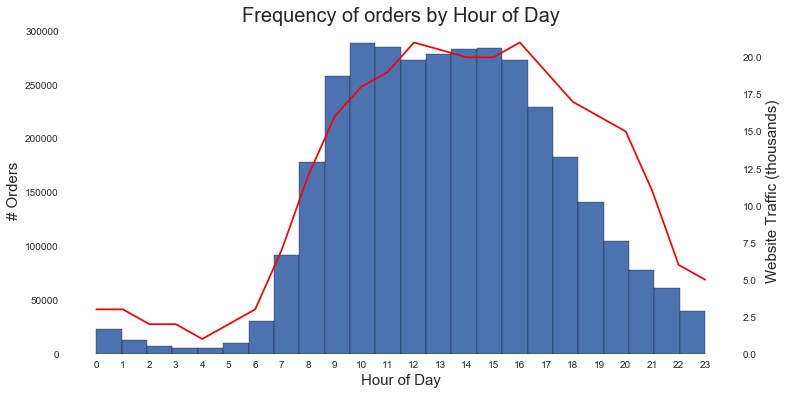

In [49]:
x=[]
i=0
while i<24:
    x.append(i)
    i+=1
y = [3,3,2,2,1,2,3,7,12,16,18,19,21,20.5,20,20,21,19,17,16,15,11,6,5]
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax=plt.subplots(figsize=(12,6))
ax.hist('order_hour_of_day',data=orders,bins=24,ec='black')
ax2 = ax.twinx()
ax2.plot(y, color="red")
ax.set_title("Frequency of orders by Hour of Day",fontsize = 20)
plt.xticks(x,fontsize=12)
ax.set_xlabel("Hour of Day",fontsize = 15)
ax.set_ylabel("# Orders",fontsize = 15)
ax2.set_ylabel(r"Website Traffic (thousands)",fontsize = 15)
ax.grid(False)
ax2.grid(False)
ax.set_facecolor('white')
plt.show()

## What percentage of the last order do the cutomers reorder?

Here, we are analyzing how many items does a customer purchase in one order. We also analyze how many items bought were common to his previous order. 

This analysis can be crucial because if most of our customers would re-order at least half of their items, it will be handy to put a 'last order' tab on the website. This will save thier time in selecting items and putting them in the order cart. They would just modify their previous order and add extra items to thier new cart. This will enhance the user experience. 

### Computational steps/complexity

1. The data for products in every order for all the customers has more than 34 million rows. It can not be directly merged with the 'orders' data to get a user id and a order id with every product. We therefore split the data into chunks of 1 million each and merge each chunk of data with the 'orders' dataset. This gives us a list of merged dataframes which we can easily concatenate. 

2. The next step involves calculating the total items ordered in each order for every customer and also know the count of items that are repeated.

3. We then concatenate all the dataframes and calculate the percentage of re-ordered items in every basket. 

4. We groupby the data according to user_id and calculate the mean and median percentage of repeated items for every user. 

5. We create a histogram of mean percentage of repeated items and get to know the number of customers for every bin of 10% percent each

In [35]:
outResult1=[] # creating an empty list to append chunks of dataframes after calculating the product count and re-ordered items
chunksize = 10 ** 6 #chunk size value of 1 million
#initializing a for loop to merge the chucks of dataframe from 'prior' datafile with 'orders' datafile
for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id', 'reordered'],
                            dtype = {'order_id':np.int32,'product_id':np.int32,'reordered':np.int32}, index_col=False, chunksize = chunksize):
    #merging dataframes
    order_prior_merged = pd.merge(left = chunk, right = orders, on = 'order_id', how = 'inner')
    #code for total products count in each order for every user
    #code also for knowing how many items are repeated/reordered in two consecutive orders for each customer
    order_prior = (order_prior_merged.groupby(['user_id','order_id'])
                   .agg({'product_id': 'count', 'reordered': 'sum'})#calculating product count and total reordered/repeated items
                   .reset_index()
                   .rename(columns={'product_id':'products_count'}))#reanaming the column name to product count
    order_prior = pd.DataFrame(order_prior)
    outResult1.append(order_prior)#appending every chunk of merged dataframe to a list. Total 34 dataframes will be created

In [36]:
order_product_reordered = pd.DataFrame(pd.concat(outResult1))#concatenating all the dataframes within a list
#below code is for calculating the percentage of items that are reordered/repeated among all the items that were purchased in each order

order_product_reordered['percentage_reordered'] = ((order_product_reordered.reordered)/(order_product_reordered.products_count))*100
order_product_reordered = order_product_reordered.sort_values(by=['user_id','order_id'])#sorting values according to the user
order_product_reordered.head(2)#checking the sorted file 
groupByUser = order_product_reordered.groupby('user_id') #group, consider only contributions for each user

#finding the mean and median of percentage of re-ordered items for each user
reordered_byUser = groupByUser['percentage_reordered'].aggregate([np.mean, np.median])
reordered_byUser = pd.DataFrame(reordered_byUser)#creating it into a dataframe
reordered_byUser = reordered_byUser.reset_index().rename(columns = {'mean': 'Avg_reorder', 'median': 'Median_reorder'})
#renaming columns

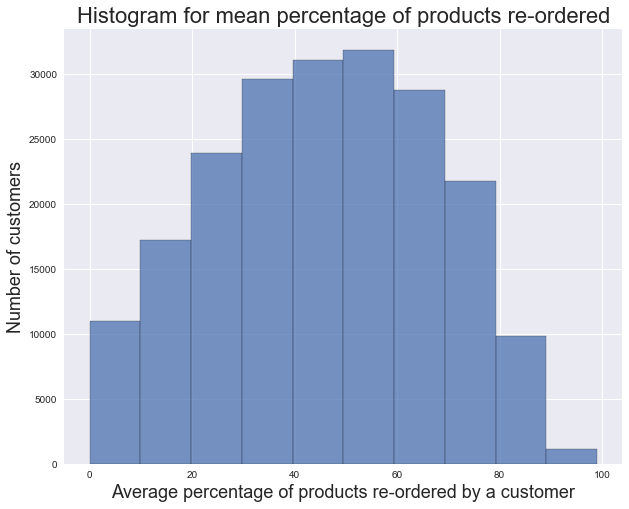

In [37]:
#code for creating a histogram of mean percentage of items re-ordered in a particular order
reordered_byUser.hist(column ='Avg_reorder', bins = 10, figsize = [10, 8], histtype = 'bar', ec = 'black', alpha= 0.75)
plt.xlabel('Average percentage of products re-ordered by a customer', fontsize = 18)
plt.ylabel('Number of customers', fontsize = 18)
plt.title('Histogram for mean percentage of products re-ordered', fontsize=22)
plt.show()

### Results
- This analysis in a form of histogram shows us that most Instacart customers repeat at least 40% percent of the items in their order. 
- It makes sense to put a re-order tab on our website and enhance user experience.

## Which department constitutes the major proportion of their purchase?

The purpose of this analysis is to identify customers who are purchasing products in a specific department and give them incentives to maximize revenue for Instacart. For example, is one customer visits 10 dairy departments and 5 other departments, that means that customer is using dairy departments the most, and about 66% of his/her time has been spent in a dairy department.

### Computational Steps
1. First, from the order data, we calculated which departments the customers visit per order. We deleted all duplicates in this stage. For example, if two vegetables were purchased in one order, we regarded it as if the customer visited the vegetable department one time in that order.

2. We grouped data by ‘user id’ level. Since we needed to figure out the number of visits by each user, we aggregated the data set.

3. We figured out which departments the customers visit the most by each customer level, the total number of visits for all departments, and the total number of visits for the specific department that the customer visits most.

4. We calculated the utilization of specific departments compared to all departments and selected customers only over 30% of utilization, since we regard those customers as frequent users for a specific department.

5. Based on pricing data, we figured out how much of the revenue has been generated from those specific customers, and what the expected revenue growth is from future strategy. (Expected growth percent is from external research, which is 15%.)


#### Aggregating Data

In [3]:
import pandas as pd
departments = pd.read_csv("master_products.csv", usecols=["department_id","department","min","max"])
departments = departments.sort_values('department_id', ascending=False).drop_duplicates('department_id').sort_index()
aisle = pd.read_csv("aisles.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [4]:
products_aisle = products.merge(aisle, on="aisle_id", how='inner')
products_aisle_departments = products_aisle.merge(departments, on="department_id", how="inner")


In [5]:
order_prior_all = order_products_prior.merge(products_aisle_departments, on="product_id", how="left")

In [6]:
order_prior_all_final = orders.merge(order_prior_all, on="order_id", how="inner")

In [7]:
userid_department = order_prior_all_final[["user_id", "order_number","department"]]
userid_department_group = userid_department.groupby(["user_id","order_number","department"]).count()

In [8]:
userid_department_group = userid_department_group.reset_index()
userid_department_final = userid_department_group.groupby(["user_id","department"]).count().reset_index()
userid_department_final.sort_values(["user_id","order_number"], ascending = False)
userid_department_final_1 = pd.pivot_table(userid_department_final,index=["user_id"],columns=["department"], values=["order_number"])

In [9]:
userid_department_final_2 = userid_department_final_1["order_number"]

#### Finding maximum and minimum values

In [10]:
userid_department_final_2["Max"] = userid_department_final_2.apply(np.max, axis=1)
userid_department_final_2["Total"] = userid_department_final_2.apply(np.sum, axis=1)

C:\Users\ktaey\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ktaey\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
department_set = list(set(order_prior_all_final["department"]))

In [12]:
def MaxValue(row):
    a = []
    for i in department_set:
        if row[i] == row["Max"]:
            return i

In [13]:
userid_department_final_2["Max Value"] = userid_department_final_2.apply(MaxValue, axis = 1)

C:\Users\ktaey\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Creating a chart to figure out the overall distribution

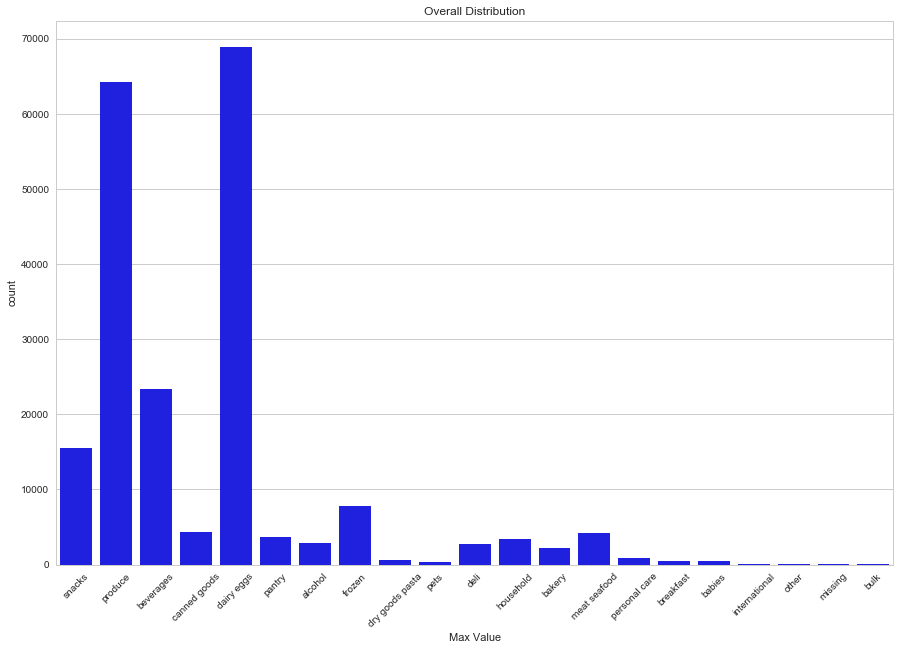

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (15,10))
sns.countplot(userid_department_final_2["Max Value"], color = "blue")
plt.xticks(rotation = 45)
ax.set_title("Overall Distribution")


#### Figuring out the utilization distribution

In [15]:
def percentage(row):
    return float(row["Max"]) / row["Total"]

In [16]:
userid_department_final_2["Percent"] = userid_department_final_2.apply(percentage, axis = 1)

C:\Users\ktaey\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


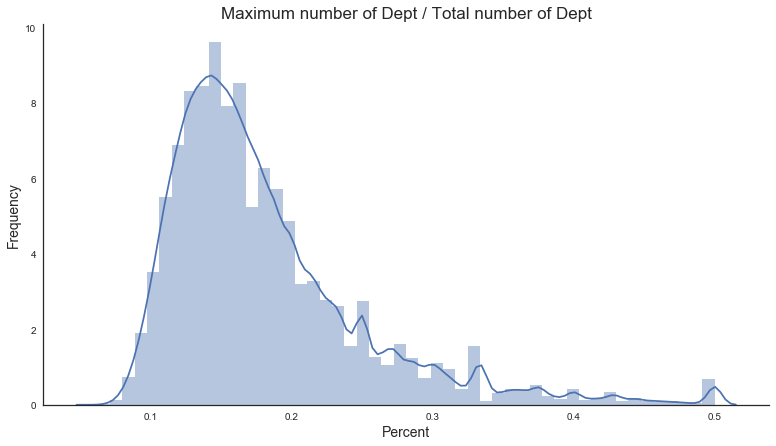

In [17]:
sns.set_style("white")

fig, ax = plt.subplots(figsize = (13,7))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title("Maximum number of Dept / Total number of Dept", fontsize = 17)
ax.set_ylabel("Frequency", fontsize = 14)
ax.set_xlabel("Percent", fontsize = 14)

sns.distplot(userid_department_final_2["Percent"], kde=True)

#### Pick up the cutting point as 0.3, and find the distribution of products from those customers

In [18]:
userid_department_final_2_30 = userid_department_final_2[userid_department_final_2["Percent"] > 0.3]
userid_30 = pd.DataFrame(userid_department_final_2_30.reset_index()[["user_id","Max Value"]])
userid_30_master = userid_30.merge(order_prior_all_final, on = "user_id", how="left")
userid_30_master = userid_30_master[userid_30_master["Max Value"] == userid_30_master["department"]]

In [19]:
def price(row):
    a = np.random.choice(range(row["min"],row["max"]))
    return a

In [20]:
userid_30_master["Price"] = userid_30_master.apply(price, axis = 1)

In [21]:
userid_30_master_agg = userid_30_master.groupby("department").sum().reset_index()[["department","Price"]]
userid_30_master_agg = userid_30_master_agg.sort_values("Price",ascending=False)

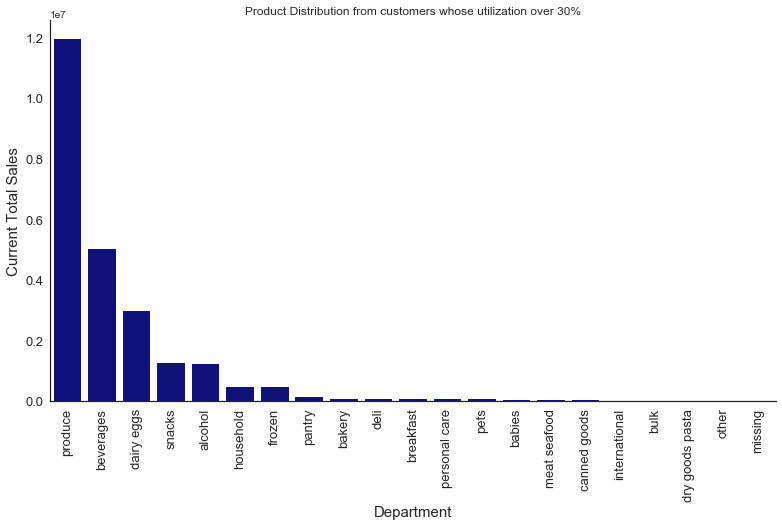

In [22]:
fig, ax = plt.subplots(figsize = (13,7))

plt.xticks(rotation = 90)

sns.barplot(x = userid_30_master_agg["department"], y = userid_30_master_agg["Price"], color="darkblue")
plt.xticks(fontsize= 13)
plt.yticks(fontsize = 13)
ax.set_xlabel("Department", fontsize = 15)
ax.set_ylabel("Current Total Sales", fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Product Distribution from customers whose utilization over 30%")

#### Revenue generated from customers whose utilization is over 30

In [23]:
userid_30_master_agg_agg = np.sum(userid_30_master_agg["Price"])
userid_30_master_agg_agg

23951246

#### Expected Revenue Growth

In [24]:
userid_30_master_agg_agg_15 = userid_30_master_agg_agg * 1.15
userid_30_master_agg_agg_15

27543932.899999999

# Conclusion

In conclusion, we can say that we have uncovered a lot of information about instacart customers and have also found ways to utilize this information to increase our revenue. We figured out some customers who are using specific departments the most, and common characteristics of products they are using which is price sensitive. Therefore, Instacart could leverage this information to make effecitve marketing strategies to maximize their profits.

### Recommendations

1) Provide a product recommendation system on the website based on the information we have on product affinities. This could **potentially** increase the number of items bought by the customers and result in a $25 million increase in revenue.

2) We recommend to introduce a 'last order' tab/button on the website and app. This will make it easier and quicker to select items into a order cart, and also enhace user experience. 

3) Work on targetting those customers who do not buy frequently. This can be done by introducing 
    - Time Bound coupon
    - Reminder emails
    
4) Incentivising the part-time Insta-Partners for them to work extra for the 6-9pm slot

5) Offer discount to customers with high specific Departmental utilization (upto 5% discount)

# Appendix  : Additional Analysis

## Aisle Affinity Analysis

After understanding the affinity among departments we now perform the affinity analysis at an aisle level.


In [3]:
############################################################################################################################
################# Code to calculate the affinity between aisles from 50000 random orders (100 iterations)##############
############################################################################################################################

aisle_affinity_list = []
for i in range(100):
    # Select a set of 50000 random orders
    total_orders = 50000
    order_list = pd.DataFrame(random.sample(orders.order_id[orders.eval_set == 'prior'],total_orders))
    order_list.rename(columns={0:'order_id'},inplace=True)

    ## Read the order products data in chunks for only selected orders
    outResult=[]
    chunksize = 10 ** 6
    for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                             dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
        chunk1 = pd.merge(left = chunk, right = order_list,on = 'order_id', how = 'inner')
        outResult.append(chunk1)

    order_prod_rand = pd.DataFrame(pd.concat(outResult))

    ## Merging product hierarchy to order product
    order_prod_aisle_rand = pd.merge(left = order_prod_rand, right = products, on = 'product_id',how='inner')

    ## Order aisle level data
    order_aisle_rand = order_prod_aisle_rand.groupby(['order_id','aisle_id'])['product_id'].count().reset_index()

    order_aisle_rand = order_aisle_rand.loc[:,['order_id','aisle_id']]

    ## Calculating orders for each aisle
    aisle_ord_count = order_aisle_rand.groupby(['aisle_id']).count().reset_index()

    aisle_ord_count.rename(columns={'order_id':'count_orders'},inplace=True)

    ## Cross joining to get pairs of products in each order
    order_aisle_rand_cross = pd.merge(left = order_aisle_rand, right = order_aisle_rand, on = 'order_id', how= 'inner')

    order_aisle_rand_cross = order_aisle_rand_cross[order_aisle_rand_cross['aisle_id_x']!=order_aisle_rand_cross['aisle_id_y']]

    order_aisle_rand_cross.rename(columns= {'aisle_id_x':"driver_aisle","aisle_id_y":"driven_aisle"},inplace=True)

    aisle_common_orders = order_aisle_rand_cross.groupby(['driver_aisle','driven_aisle']).count().reset_index()

    aisle_common_orders.rename(columns={'order_id':'count_common_orders'},inplace=True)

    ## join the above table to aisle order count to get number of driver and driven orders
    aisle_aff = aisle_common_orders.merge(aisle_ord_count,left_on = 'driver_aisle',right_on = 'aisle_id',how = 'inner')

    aisle_aff.rename(columns={'count_orders':'driver_orders'},inplace=True)

    aisle_aff = aisle_aff.drop('aisle_id',axis = 1)

    aisle_aff = aisle_aff.merge(aisle_ord_count,left_on = 'driven_aisle',right_on = 'aisle_id',how = 'inner')

    aisle_aff.rename(columns={'count_orders':'driven_orders'},inplace=True)
    aisle_aff = aisle_aff.drop('aisle_id',axis = 1)
    
    aisle_aff.sort_values(['driver_aisle','driven_aisle'],ascending=[1,1], inplace=True)
    
    ## Add total orders as 50000
    aisle_aff['Total_orders'] = total_orders
    
    ## Calculate affinity
    aisle_aff['Confidence'] = aisle_aff['count_common_orders'] / aisle_aff['driven_orders']
    aisle_aff['Support'] = aisle_aff['driver_orders'] / aisle_aff['Total_orders']
    aisle_aff['Affinity'] = aisle_aff['Confidence'] / aisle_aff['Support']
    aisle_aff['iteration'] = i
    aisle_affinity_list.append(aisle_aff)

## Remove the combinations with bottom 5% support value in each iteration    
for i in range(100):
    aisle_affinity_list[i] = aisle_affinity_list[i][aisle_affinity_list[i]["Support"] >= \
                                                aisle_affinity_list[i]['Support'].quantile(0.05)]

#### Combine the affinity results from all iterations

In [4]:
aisle_affinity = pd.DataFrame(pd.concat(aisle_affinity_list))

In [5]:
## Calculate the mean and standard deviation of affinities calculated from 100 iterations
aisle_affinity_final = aisle_affinity.groupby(['driver_aisle','driven_aisle']).agg({'Affinity':[np.mean,np.median, np.std]}).reset_index()

#### Preparing the final affinity table

In [6]:
aisle_affinity_final.columns = [' '.join(col).strip() for col in aisle_affinity_final.columns.values]

aisle_affinity_final = aisle_affinity_final.merge(aisles,left_on= 'driver_aisle',right_on='aisle_id',how = 'inner')

aisle_affinity_final.rename(columns={'aisle':'driver_name'},inplace=True)
aisle_affinity_final.drop('aisle_id',axis=1,inplace=True)

aisle_affinity_final = aisle_affinity_final.merge(aisles,left_on= 'driven_aisle',right_on='aisle_id',how = 'inner')
aisle_affinity_final.rename(columns={'aisle':'driven_name'},inplace=True)
aisle_affinity_final.drop('aisle_id',axis=1,inplace=True)

aisle_affinity_final.sort_values(['Affinity mean'],ascending=0,inplace=True)

aisle_affinity_table = pd.pivot_table(aisle_affinity_final, values='Affinity mean', index=['driver_name'],
                    columns=['driven_name'], aggfunc=np.sum)

### Top affinied aisles

In [7]:
aisle_affinity_final.head(20)

,driver_aisle,driven_aisle,Affinity mean,Affinity median,Affinity std,driver_name,driven_name
3463,62,28,39.251526,39.362963,2.545052,white wines,red wines
7881,28,62,39.251526,39.362963,2.545052,red wines,white wines
17341,62,134,27.783816,27.702840,4.115925,white wines,specialty wines champagnes
7983,134,62,27.525569,27.581855,3.921960,specialty wines champagnes,white wines
17307,28,134,26.956535,26.748023,3.861851,red wines,specialty wines champagnes
3533,134,28,26.846966,26.597875,3.902315,specialty wines champagnes,red wines
3299,28,27,22.729078,22.735400,2.244002,red wines,beers coolers
3429,27,28,22.729078,22.735400,2.244002,beers coolers,red wines
16102,134,124,21.850721,21.757969,3.454448,specialty wines champagnes,spirits
17400,124,134,21.713502,21.683151,3.699864,spirits,specialty wines champagnes


#### Plotting affinities between aisles

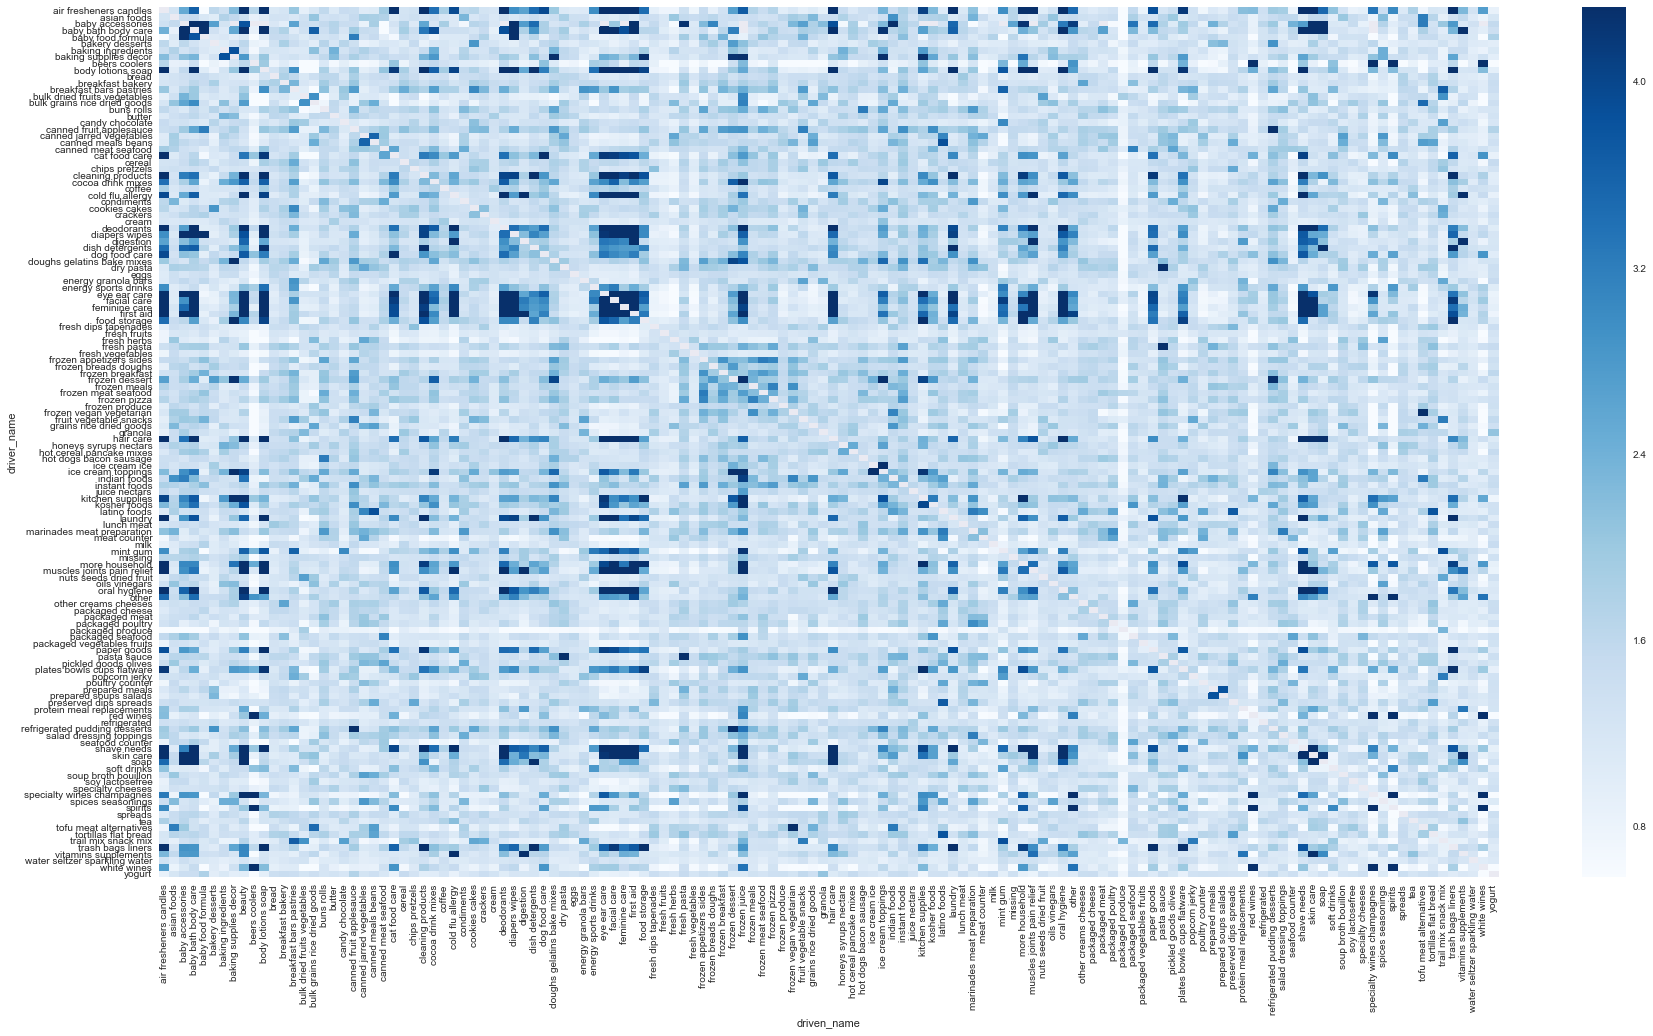

In [8]:
fig, ax = plt.subplots(figsize=(30, 16))
ax = sns.heatmap(aisle_affinity_table, robust = True, cmap = "Blues")

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('seabornPandas1.png', dpi=300)
plt.show()

### What are the most popular departments?

In [ ]:
order_dept_all_1.head()

### What are most popular aisles?


In [9]:
order_aisle_all=[]
chunksize = 10 ** 6

for chunk in pd.read_csv("order_products__prior.csv",usecols=['order_id','product_id'],
                         dtype = {'order_id':np.int32,'product_id':np.int32}, index_col=False, chunksize = chunksize):
    chunk1 = pd.merge(left = chunk, right = products, on = 'product_id', how = 'inner')
    chunk2 = chunk1.groupby(['order_id','aisle_id'])['product_id'].count().reset_index()
    chunk3 = chunk2.groupby(['aisle_id'])['order_id'].count().reset_index()
    order_aisle_all.append(chunk3)

order_aisle_all_1 = pd.DataFrame(pd.concat(order_aisle_all))

order_aisle_all_1 = order_aisle_all_1.groupby(['aisle_id'])['order_id'].sum().reset_index()

order_aisle_all_1.rename(columns={'order_id':'no_of_orders'}, inplace= True)

order_aisle_all_1 = order_aisle_all_1.merge(aisles,on='aisle_id',how = 'inner')

order_aisle_all_1['aisle_penetration'] = order_aisle_all_1['no_of_orders'] / (len(orders.order_id[orders.eval_set == 
                                                                                                 'prior'].unique()))

order_aisle_all_1.sort_values(['aisle_penetration'],ascending=0,inplace=True)

order_aisle_all_1.head()

,aisle_id,no_of_orders,aisle,aisle_penetration
23,24,1790774,fresh fruits,0.557028
82,83,1427636,fresh vegetables,0.444072
122,123,1179245,packaged vegetables fruits,0.366809
119,120,847083,yogurt,0.263489
83,84,785987,milk,0.244485
